# Drivable Area Detection Project!
 Aim: To predict drivable area in an image using Unet segmentation.


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/MyDrive/Lane_segmentaion")
!ls

Mounted at /content/drive
dataset  dataset.zip  lane_segment.pth	output.mp4


**GPU**<p>
This shouldn't be needed. You can run it just in case.<p>
Know that Colab uses Tensorflow 2.0 that included Keras.<p>
Be sure to use GPU environment by selecting **Runtime** > **GPU** above.

In [4]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.1.0+cu121
cpu


# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>


**Use the provided pickle file**<p>
I have downloaded the images and labels. It took a few hours.<p>
I selected **3,000 images** and **their associated labels** and put them into **2 separate pickle files**. <p>Each image has been resized to **160x80** for memory reasons. <p>
**Original 1280x720** images are also available in the course.

<p>-<p>In this part you will load the dataset and adapt it so it fits your neural network.

## Load the Dataset, Visualize Images & Labels


**Library Import**

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

**Load the Pickle files**

In [6]:
with open("dataset/images_3000_160.p", 'rb') as f:
    images = pickle.load(f)

with open("dataset/labels_3000_160.p","rb") as f:
    labels = pickle.load(f)

## NOTE : File has been pickle.dump() with Python 2 so this syntax is necessary to open it with Python 3. Otherwise the following would be enough :
#images = pickle.load(open("images.p","rb", encoding='latin1)) # Pickle Dump using Python 2
#images = pickle.load(open("images.p","rb")) ## Pickle Dump using Python 3

**Display a random image and its label**<p>
Print dataset information

Text(0.5, 1.0, 'Label')

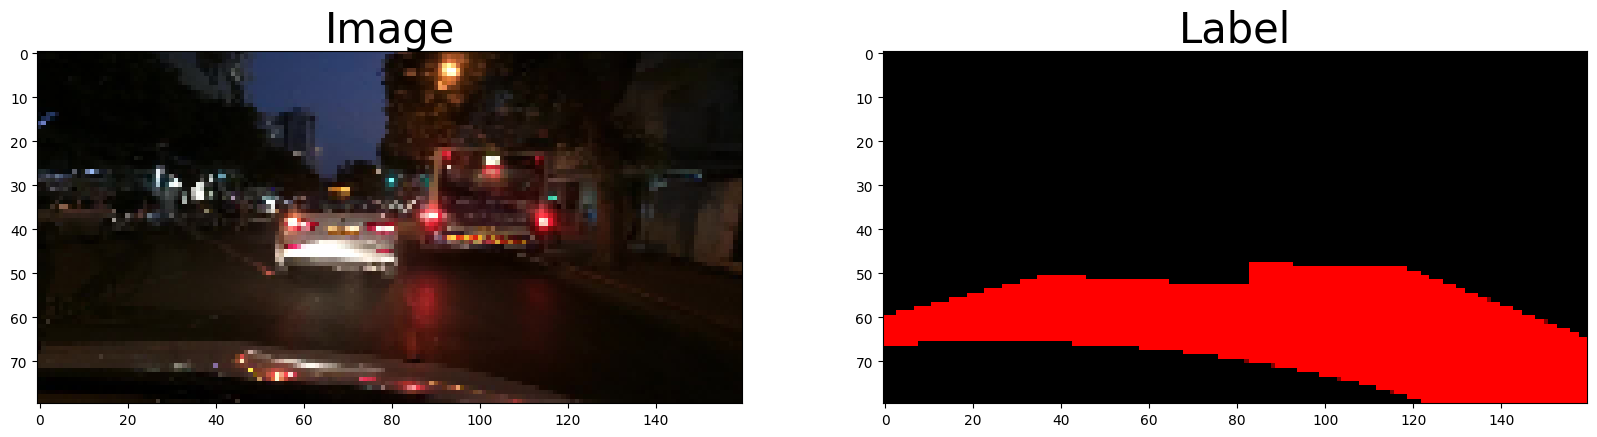

In [7]:
import random
index = random.randint(0,len(labels))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)

In [8]:
print("There are "+ str(len(images))+ " images and "+ str(len(labels)) +" labels in the dataset")
print("Shape of an image")
print(images[0].shape)
print("Shape of a Label")
print(labels[0].shape)
print("Images range from "+str(np.amin(images[0]))+" to "+str(np.amax(images[0])))
print("Labels range from "+str(np.amin(labels[0]))+" to "+str(np.amax(labels[0])))

There are 3000 images and 3000 labels in the dataset
Shape of an image
(80, 160, 3)
Shape of a Label
(80, 160, 3)
Images range from 0 to 255
Labels range from 0.0 to 1.0


## Labels & Output


To fit an Encoder-Decoder Neural Network; you will need to preprocess your labels. Currently, **your labels are RGB images of dimension 160x80x3.**

As you can see here, we have multiple options, and I will detail all 3 of them.<p>
![Texte alternatif…](http://ronny.rest/media/tutorials/segmentation/ZZZ_IMAGES_DIR/label_formats.jpeg)


*   **A- Class Labels**
Each Pixel is a number representing a class.<p>
In this case, the output is simply a matrix of 1 channel with these numbers.
*   **B- RGB Mappings**
This is what we currently have, the labels are in RGB format.<p>
As we are only working with 2 classes, and they all are colored either red or blue, it's quite easy to work with.
If you ever get more classes, let's say 7, some pixels will not be 0 or 255, they will have some intensity value and it will get more complicated.
Preprocessing is therefore necessary.
*   **C- One Hot Vectors**
Similar to format A, but one-hot encoded.


**Your Choice**

For this project, you have the choice to detect only the driveable area or the driveable area + the adjacent lanes. <p>

You will therefore
*   Remove every blue pixel and face a 1-channel problem (driveable area detection)
*   Keep the blue pixel, use 3 channels.<p>**One easy solution would be to convert every black pixel into a green one.**
Then, the network would have to label a pixel as either green (background), red (driveable), or blue (adjacent).


In [9]:
# augmented_labels = list()
# for label in labels:
#   for i in range((label.shape)[0]):
#     for j in range((label.shape)[1]):
#       if np.all(label[i][j] == [0,0,0]):
#         label[i][j] = [0,1,0]
#   augmented_labels.append(label)

##for improved time complexity

import numpy as np

augmented_labels = []

for label in labels:
    mask = np.all(label == [0, 0, 0], axis=2)  # Create a boolean mask for pixels with color [0, 0, 0]
    label[mask] = [0, 1, 0]  # Update pixels where the mask is True
    augmented_labels.append(label)

**Data Augmentation**


6000
6000


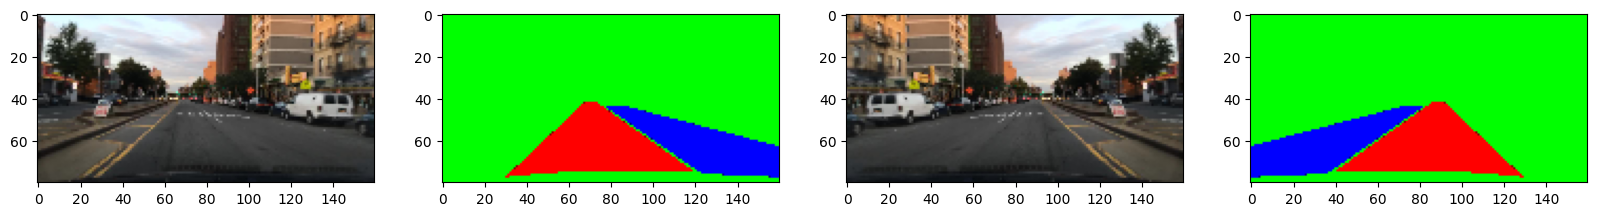

In [10]:
def flip_image(img):
    return cv2.flip(img, 1)

flipped_images = []
flipped_labels = []

for i in images:
    flipped_images.append(flip_image(i))

for i in augmented_labels:
    flipped_labels.append(flip_image(i))

images.extend(flipped_images)
augmented_labels.extend(flipped_labels)
print(len(images))
print(len(augmented_labels))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(images[0])
ax2.imshow(augmented_labels[0])
ax3.imshow(flipped_images[0])
ax4.imshow(flipped_labels[0])


In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

Transform the input data


In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
dataset = CustomDataset(images, augmented_labels,transform = transform)

In [ ]:
train,val = random_split(dataset,[0.7,0.3])

In [ ]:
train_ds = DataLoader(train,shuffle=True,batch_size = 16)
val_ds = DataLoader(val,shuffle=True,batch_size = 16)

In [ ]:
im,lab = next(iter(train_ds))

torch.Size([16, 3, 80, 160])


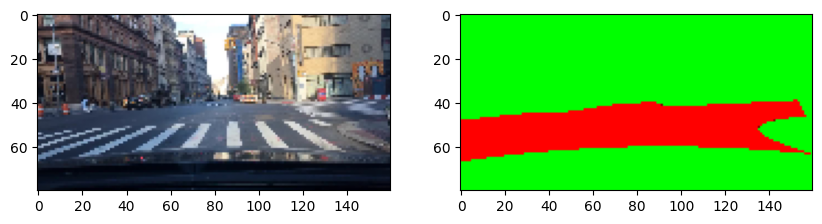

In [ ]:
im,lab = next(iter(train_ds))
print(im.shape)
f, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(torch.permute(im[0],(1,2,0)))
ax2.imshow(torch.permute(lab[0],(1,2,0)))


# <a name="Model"></a>2. Create A Deep Learning Model


**Imports**

In [11]:
import torch.nn as nn
from torch.nn import Conv2d,BatchNorm2d,ReLU,LeakyReLU,MaxPool2d,UpsamplingBilinear2d
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

**Build your Model**

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
model = UNET()
model = model.to(device)
from torchsummary import summary
summary(model,(3,80,160))

## Hyperparameters

In [ ]:
import time
from tqdm import tqdm
learning_rate= 0.001
# Optimiser
optimiser = Adam(model.parameters(), lr = learning_rate)
# Loss Function
loss_fn = CrossEntropyLoss()

num_of_epochs = 50


In [ ]:
def visualize_masks(image,pred_np):
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(image)  # Assuming images[45] is the original image
  plt.axis('off')

  # Visualize the predicted output
  plt.subplot(1, 2, 2)
  plt.title('Predicted Output')
  plt.imshow(pred_np[0].permute(1,2,0))  # Adjust the colormap based on your task
  plt.axis('off')

def convert_to_visualize(image):
  return image[0].cpu().permute(1,2,0)

## Simple Traning script

In [ ]:
for epoch in range(num_of_epochs):
    model.train()
    running_loss = 0.0
    val_running_loss = 0.0

    for batch in tqdm(train_ds, desc=f'Epoch {epoch + 1}/{num_of_epochs}'):
      image,target = batch
      inputs, masks = image.to(device), target.to(device)
      optimiser.zero_grad()
      # Forward pass
      outputs = model(inputs)
      loss = loss_fn(outputs, masks)

      # Backward pass and optimization

      loss.backward()
      optimiser.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_ds)
    print(f"Epoch {epoch + 1}/{num_of_epochs}, Training_Loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():  # No need to compute gradients during validation
      for val_batch in tqdm(val_ds, desc=f'Validation'):
          val_image, val_target = val_batch
          val_inputs, val_masks = val_image.to(device), val_target.to(device)

          # Forward pass
          val_outputs = model(val_inputs)
          val_loss = loss_fn(val_outputs, val_masks)

          val_running_loss += val_loss.item()

    val_epoch_loss = val_running_loss / len(val_ds)
    print(f"Validation Loss: {val_epoch_loss:.4f}")

### Save the model


In [ ]:
# After your training loop
torch.save(model.state_dict(), '/content/drive/MyDrive/Lane_segmentaion/lane_segment.pth')

### Load Saved Model.
model cell need to be exicuted

In [17]:
import torch

filepath = '/content/drive/MyDrive/Lane_segmentaion/lane_segment.pth'
model = UNET()

# Correct placement of map_location
model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu'))) # if you are using cuda remove the cpu
model.eval()


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

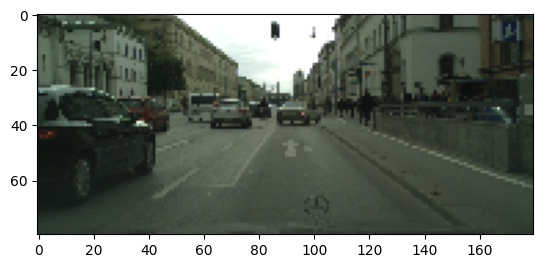

In [18]:
img = cv2.imread("/content/drive/MyDrive/Task_02/Task_02_data/val/images/munich_000067_000019_leftImg8bit.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#
img = cv2.resize(img,(180,80))
plt.imshow(img)

### Prediction

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


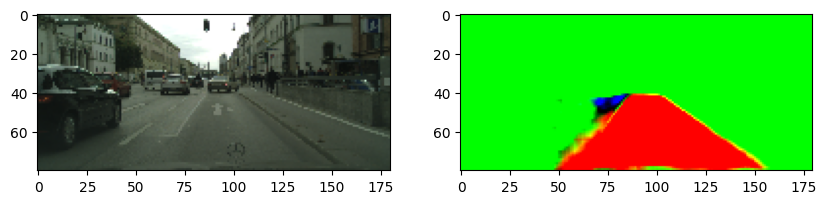

In [19]:
im = (transform(img)).unsqueeze(0).to(device)
pred = model(im)
pred = pred.cpu()
pred_img = pred[0].permute(1,2,0).detach().numpy()
f, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(img)
ax2.imshow(pred_img)
plt.show()
#
# plt.imshow(pred_np[0].transpose(pred_np,(1,2,0)))

##Blending Masks into image

(80, 180, 3)


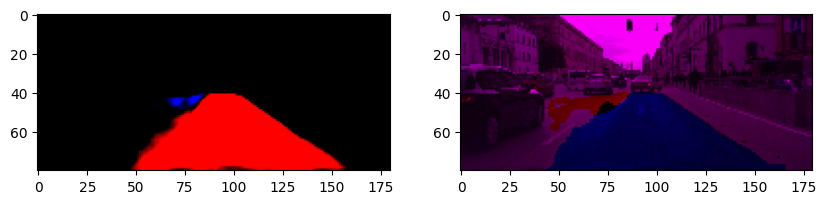

In [20]:
def rgb_channel(img, thresholding=False, thresh=150):
    image = np.transpose(img,(1,2,0))
    if thresholding:
      ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    r, g, b = cv2.split(image)

    return r, g, b
import cv2
import numpy as np
import torch

# Assuming 'images' is a list of images and 'model' is your trained PyTorch model
# Make sure 'transform' and 'device' are defined appropriately

# Placeholder data (replace with your actual data)
input_image = img
h, w, d = input_image.shape
network_image = input_image.copy()
input_image = cv2.resize(input_image,(180,80))

# Assuming 'transform' is your PyTorch transform
im = transform(network_image).unsqueeze(0).to(device)

# Assuming 'model' is your PyTorch model
pred = model(im)
test = pred[0].cpu().detach().numpy()
print(np.transpose(test,(1,2,0)).shape)
# Processing the Prediction
r, g, b = rgb_channel(test,thresh=40)
#r1,g1,b1 = rgb_channel(input_image)

# Creating Visualization
blank = np.zeros_like(r).astype(np.uint8)
lane_image = np.dstack((r, blank, b))
lane_image = cv2.resize(lane_image, (w, h))


result = cv2.bitwise_and(input_image,lane_image.astype(np.uint8),)
#result = cv2.addWeighted(lane_image.astype(np.uint8), 1,input_image, 1, 0)
f, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(lane_image)
ax2.imshow(result)
plt.show()






##creating pipeline for testing video

In [ ]:
def run(input_image):
    input_image = cv2.resize(input_image,(360,180))
    h, w, d = input_image.shape
    network_image = input_image.copy()


    # Assuming 'transform' is your PyTorch transform
    im = transform(network_image).unsqueeze(0).to(device)

    # Assuming 'model' is your PyTorch model
    pred = model(im)
    test = pred[0].cpu().detach().numpy()
    print(np.transpose(test,(1,2,0)).shape)
    # Processing the Prediction
    r, g, b = rgb_channel(test,thresh=40)
    #r1,g1,b1 = rgb_channel(input_image)

    # Creating Visualization
    blank = np.zeros_like(r).astype(np.uint8)
    lane_image = np.dstack((r, blank, b))
    lane_image = cv2.resize(lane_image, (w, h))


    result = cv2.bitwise_and(lane_image.astype(np.uint8),input_image)
    #result = cv2.addWeighted(lane_image.astype(np.uint8), 0.4, input_image, 1.3, 0)
    return result

# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [ ]:
from moviepy.editor import VideoFileClip
video_file = "/content/project_video.mp4"
clip = VideoFileClip(video_file).subclip(0,30).set_fps(15)
white_clip = clip.fl_image(run1)
%time white_clip.write_videofile("output.mp4",audio=False)

t:   1%|▏         | 6/450 [35:07<16:02,  2.17s/it, now=None]

(180, 360, 3)
Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4




t:   0%|          | 2/450 [00:03<14:47,  1.98s/it, now=None]

(180, 360, 3)



t:   1%|          | 3/450 [00:07<18:54,  2.54s/it, now=None]

(180, 360, 3)



t:   1%|          | 4/450 [00:14<31:27,  4.23s/it, now=None]

(180, 360, 3)



t:   1%|          | 5/450 [00:18<31:41,  4.27s/it, now=None]

(180, 360, 3)



t:   1%|▏         | 6/450 [00:22<30:45,  4.16s/it, now=None]

(180, 360, 3)



t:   2%|▏         | 7/450 [00:28<35:21,  4.79s/it, now=None]

(180, 360, 3)



t:   2%|▏         | 8/450 [00:33<34:31,  4.69s/it, now=None]

(180, 360, 3)



t:   2%|▏         | 9/450 [00:35<28:59,  3.94s/it, now=None]

(180, 360, 3)



t:   2%|▏         | 10/450 [00:37<23:56,  3.27s/it, now=None]

(180, 360, 3)



t:   2%|▏         | 11/450 [00:38<20:31,  2.80s/it, now=None]

(180, 360, 3)



t:   3%|▎         | 12/450 [00:40<18:41,  2.56s/it, now=None]

(180, 360, 3)



t:   3%|▎         | 13/450 [00:43<19:00,  2.61s/it, now=None]

(180, 360, 3)



t:   3%|▎         | 14/450 [00:46<18:32,  2.55s/it, now=None]

(180, 360, 3)



t:   3%|▎         | 15/450 [00:47<16:42,  2.31s/it, now=None]

(180, 360, 3)



t:   4%|▎         | 16/450 [00:49<15:29,  2.14s/it, now=None]

(180, 360, 3)



t:   4%|▍         | 17/450 [00:51<14:32,  2.01s/it, now=None]

(180, 360, 3)



t:   4%|▍         | 18/450 [00:53<13:54,  1.93s/it, now=None]

(180, 360, 3)



t:   4%|▍         | 19/450 [00:54<13:26,  1.87s/it, now=None]

(180, 360, 3)



t:   4%|▍         | 20/450 [00:57<14:23,  2.01s/it, now=None]

(180, 360, 3)



t:   5%|▍         | 21/450 [00:59<15:47,  2.21s/it, now=None]

(180, 360, 3)



t:   5%|▍         | 22/450 [01:02<15:44,  2.21s/it, now=None]

(180, 360, 3)



t:   5%|▌         | 23/450 [01:03<14:53,  2.09s/it, now=None]

(180, 360, 3)



t:   5%|▌         | 24/450 [01:05<14:09,  2.00s/it, now=None]

(180, 360, 3)



t:   6%|▌         | 25/450 [01:07<13:38,  1.93s/it, now=None]

(180, 360, 3)



t:   6%|▌         | 26/450 [01:09<13:22,  1.89s/it, now=None]

(180, 360, 3)



t:   6%|▌         | 27/450 [01:10<13:03,  1.85s/it, now=None]

(180, 360, 3)



t:   6%|▌         | 28/450 [01:13<14:53,  2.12s/it, now=None]

(180, 360, 3)



t:   6%|▋         | 29/450 [01:16<16:15,  2.32s/it, now=None]

(180, 360, 3)



t:   7%|▋         | 30/450 [01:18<14:55,  2.13s/it, now=None]

(180, 360, 3)



t:   7%|▋         | 31/450 [01:19<14:10,  2.03s/it, now=None]

(180, 360, 3)



t:   7%|▋         | 32/450 [01:21<13:31,  1.94s/it, now=None]

(180, 360, 3)



t:   7%|▋         | 33/450 [01:23<13:00,  1.87s/it, now=None]

(180, 360, 3)



t:   8%|▊         | 34/450 [01:25<12:37,  1.82s/it, now=None]

(180, 360, 3)



t:   8%|▊         | 35/450 [01:27<12:51,  1.86s/it, now=None]

(180, 360, 3)



t:   8%|▊         | 36/450 [01:29<14:38,  2.12s/it, now=None]

(180, 360, 3)



t:   8%|▊         | 37/450 [01:32<15:18,  2.22s/it, now=None]

(180, 360, 3)



t:   8%|▊         | 38/450 [01:34<14:21,  2.09s/it, now=None]

(180, 360, 3)



t:   9%|▊         | 39/450 [01:35<13:34,  1.98s/it, now=None]

(180, 360, 3)



t:   9%|▉         | 40/450 [01:37<13:01,  1.91s/it, now=None]

(180, 360, 3)



t:   9%|▉         | 41/450 [01:39<12:43,  1.87s/it, now=None]

(180, 360, 3)



t:   9%|▉         | 42/450 [01:41<12:25,  1.83s/it, now=None]

(180, 360, 3)



t:  10%|▉         | 43/450 [01:43<13:18,  1.96s/it, now=None]

(180, 360, 3)



t:  10%|▉         | 44/450 [01:46<14:56,  2.21s/it, now=None]

(180, 360, 3)



t:  10%|█         | 45/450 [01:48<14:56,  2.21s/it, now=None]

(180, 360, 3)



t:  10%|█         | 46/450 [01:50<14:02,  2.08s/it, now=None]

(180, 360, 3)



t:  10%|█         | 47/450 [01:51<13:27,  2.00s/it, now=None]

(180, 360, 3)



t:  11%|█         | 48/450 [01:53<12:57,  1.94s/it, now=None]

(180, 360, 3)



t:  11%|█         | 49/450 [01:55<13:23,  2.00s/it, now=None]

(180, 360, 3)



t:  11%|█         | 50/450 [01:57<13:27,  2.02s/it, now=None]

(180, 360, 3)



t:  11%|█▏        | 51/450 [02:00<14:48,  2.23s/it, now=None]

(180, 360, 3)



t:  12%|█▏        | 52/450 [02:03<15:28,  2.33s/it, now=None]

(180, 360, 3)



t:  12%|█▏        | 53/450 [02:04<14:18,  2.16s/it, now=None]

(180, 360, 3)



t:  12%|█▏        | 54/450 [02:06<13:26,  2.04s/it, now=None]

(180, 360, 3)



t:  12%|█▏        | 55/450 [02:08<12:48,  1.95s/it, now=None]

(180, 360, 3)



t:  12%|█▏        | 56/450 [02:10<12:18,  1.87s/it, now=None]

(180, 360, 3)



t:  13%|█▎        | 57/450 [02:11<12:00,  1.83s/it, now=None]

(180, 360, 3)



t:  13%|█▎        | 58/450 [02:13<12:29,  1.91s/it, now=None]

(180, 360, 3)



t:  13%|█▎        | 59/450 [02:16<14:06,  2.17s/it, now=None]

(180, 360, 3)



t:  13%|█▎        | 60/450 [02:19<14:20,  2.21s/it, now=None]

(180, 360, 3)



t:  14%|█▎        | 61/450 [02:20<13:24,  2.07s/it, now=None]

(180, 360, 3)



t:  14%|█▍        | 62/450 [02:22<12:46,  1.97s/it, now=None]

(180, 360, 3)



t:  14%|█▍        | 63/450 [02:24<12:13,  1.90s/it, now=None]

(180, 360, 3)



t:  14%|█▍        | 64/450 [02:25<11:52,  1.85s/it, now=None]

(180, 360, 3)



t:  14%|█▍        | 65/450 [02:27<11:40,  1.82s/it, now=None]

(180, 360, 3)



t:  15%|█▍        | 66/450 [02:30<12:44,  1.99s/it, now=None]

(180, 360, 3)



t:  15%|█▍        | 67/450 [02:32<14:15,  2.23s/it, now=None]

(180, 360, 3)



t:  15%|█▌        | 68/450 [02:35<14:00,  2.20s/it, now=None]

(180, 360, 3)



t:  15%|█▌        | 69/450 [02:36<13:04,  2.06s/it, now=None]

(180, 360, 3)



t:  16%|█▌        | 70/450 [02:38<12:26,  1.96s/it, now=None]

(180, 360, 3)



t:  16%|█▌        | 71/450 [02:40<11:58,  1.90s/it, now=None]

(180, 360, 3)



t:  16%|█▌        | 72/450 [02:41<11:40,  1.85s/it, now=None]

(180, 360, 3)



t:  16%|█▌        | 73/450 [02:43<11:30,  1.83s/it, now=None]

(180, 360, 3)



t:  16%|█▋        | 74/450 [02:46<12:59,  2.07s/it, now=None]

(180, 360, 3)



t:  17%|█▋        | 75/450 [02:49<14:07,  2.26s/it, now=None]

(180, 360, 3)



t:  17%|█▋        | 76/450 [02:50<13:17,  2.13s/it, now=None]

(180, 360, 3)



t:  17%|█▋        | 77/450 [02:52<12:36,  2.03s/it, now=None]

(180, 360, 3)



t:  17%|█▋        | 78/450 [02:55<14:07,  2.28s/it, now=None]

(180, 360, 3)



t:  18%|█▊        | 79/450 [02:57<13:03,  2.11s/it, now=None]

(180, 360, 3)



t:  18%|█▊        | 80/450 [02:59<12:23,  2.01s/it, now=None]

(180, 360, 3)



t:  18%|█▊        | 81/450 [03:01<13:23,  2.18s/it, now=None]

(180, 360, 3)



t:  18%|█▊        | 82/450 [03:04<14:24,  2.35s/it, now=None]

(180, 360, 3)



t:  18%|█▊        | 83/450 [03:06<13:34,  2.22s/it, now=None]

(180, 360, 3)



t:  19%|█▊        | 84/450 [03:08<12:38,  2.07s/it, now=None]

(180, 360, 3)



t:  19%|█▉        | 85/450 [03:09<12:00,  1.97s/it, now=None]

(180, 360, 3)



t:  19%|█▉        | 86/450 [03:11<11:32,  1.90s/it, now=None]

(180, 360, 3)



t:  19%|█▉        | 87/450 [03:13<11:09,  1.85s/it, now=None]

(180, 360, 3)



t:  20%|█▉        | 88/450 [03:15<11:02,  1.83s/it, now=None]

(180, 360, 3)



t:  20%|█▉        | 89/450 [03:17<12:34,  2.09s/it, now=None]

(180, 360, 3)



t:  20%|██        | 90/450 [03:20<13:35,  2.26s/it, now=None]

(180, 360, 3)



t:  20%|██        | 91/450 [03:22<12:38,  2.11s/it, now=None]

(180, 360, 3)



t:  20%|██        | 92/450 [03:23<11:59,  2.01s/it, now=None]

(180, 360, 3)



t:  21%|██        | 93/450 [03:25<11:28,  1.93s/it, now=None]

(180, 360, 3)



t:  21%|██        | 94/450 [03:27<11:06,  1.87s/it, now=None]

(180, 360, 3)



t:  21%|██        | 95/450 [03:29<10:51,  1.84s/it, now=None]

(180, 360, 3)



t:  21%|██▏       | 96/450 [03:31<11:12,  1.90s/it, now=None]

(180, 360, 3)



t:  22%|██▏       | 97/450 [03:33<12:34,  2.14s/it, now=None]

(180, 360, 3)



t:  22%|██▏       | 98/450 [03:36<13:08,  2.24s/it, now=None]

(180, 360, 3)



t:  22%|██▏       | 99/450 [03:38<12:16,  2.10s/it, now=None]

(180, 360, 3)



t:  22%|██▏       | 100/450 [03:39<11:38,  2.00s/it, now=None]

(180, 360, 3)



t:  22%|██▏       | 101/450 [03:41<11:23,  1.96s/it, now=None]

(180, 360, 3)



t:  23%|██▎       | 102/450 [03:43<11:20,  1.96s/it, now=None]

(180, 360, 3)



t:  23%|██▎       | 103/450 [03:45<11:19,  1.96s/it, now=None]

(180, 360, 3)



t:  23%|██▎       | 104/450 [03:48<12:36,  2.19s/it, now=None]

(180, 360, 3)



t:  23%|██▎       | 105/450 [03:51<13:29,  2.35s/it, now=None]

(180, 360, 3)



t:  24%|██▎       | 106/450 [03:53<12:41,  2.21s/it, now=None]

(180, 360, 3)



t:  24%|██▍       | 107/450 [03:54<11:56,  2.09s/it, now=None]

(180, 360, 3)



t:  24%|██▍       | 108/450 [03:56<11:24,  2.00s/it, now=None]

(180, 360, 3)



t:  24%|██▍       | 109/450 [03:58<11:10,  1.97s/it, now=None]

(180, 360, 3)



t:  24%|██▍       | 110/450 [04:00<10:48,  1.91s/it, now=None]

(180, 360, 3)



t:  25%|██▍       | 111/450 [04:02<10:55,  1.93s/it, now=None]

(180, 360, 3)



t:  25%|██▍       | 112/450 [04:05<12:14,  2.17s/it, now=None]

(180, 360, 3)



t:  25%|██▌       | 113/450 [04:07<12:45,  2.27s/it, now=None]

(180, 360, 3)



t:  25%|██▌       | 114/450 [04:09<11:50,  2.12s/it, now=None]

(180, 360, 3)



t:  26%|██▌       | 115/450 [04:11<11:15,  2.02s/it, now=None]

(180, 360, 3)



t:  26%|██▌       | 116/450 [04:12<10:53,  1.96s/it, now=None]

(180, 360, 3)



t:  26%|██▌       | 117/450 [04:14<10:43,  1.93s/it, now=None]

(180, 360, 3)



t:  26%|██▌       | 118/450 [04:16<10:37,  1.92s/it, now=None]

(180, 360, 3)



t:  26%|██▋       | 119/450 [04:19<11:31,  2.09s/it, now=None]

(180, 360, 3)



t:  27%|██▋       | 120/450 [04:21<12:32,  2.28s/it, now=None]

(180, 360, 3)



t:  27%|██▋       | 121/450 [04:23<12:01,  2.19s/it, now=None]

(180, 360, 3)



t:  27%|██▋       | 122/450 [04:25<11:19,  2.07s/it, now=None]

(180, 360, 3)



t:  27%|██▋       | 123/450 [04:27<10:45,  1.97s/it, now=None]

(180, 360, 3)



t:  28%|██▊       | 124/450 [04:29<10:22,  1.91s/it, now=None]

(180, 360, 3)



t:  28%|██▊       | 125/450 [04:30<10:07,  1.87s/it, now=None]

(180, 360, 3)



t:  28%|██▊       | 126/450 [04:32<09:59,  1.85s/it, now=None]

(180, 360, 3)



t:  28%|██▊       | 127/450 [04:35<11:22,  2.11s/it, now=None]

(180, 360, 3)



t:  28%|██▊       | 128/450 [04:38<12:17,  2.29s/it, now=None]

(180, 360, 3)



t:  29%|██▊       | 129/450 [04:39<11:21,  2.12s/it, now=None]

(180, 360, 3)



t:  29%|██▉       | 130/450 [04:41<10:42,  2.01s/it, now=None]

(180, 360, 3)



t:  29%|██▉       | 131/450 [04:43<10:14,  1.93s/it, now=None]

(180, 360, 3)



t:  29%|██▉       | 132/450 [04:45<10:01,  1.89s/it, now=None]

(180, 360, 3)



t:  30%|██▉       | 133/450 [04:46<09:49,  1.86s/it, now=None]

(180, 360, 3)



t:  30%|██▉       | 134/450 [04:49<10:11,  1.94s/it, now=None]

(180, 360, 3)



t:  30%|███       | 135/450 [04:51<11:23,  2.17s/it, now=None]

(180, 360, 3)



t:  30%|███       | 136/450 [04:54<11:41,  2.24s/it, now=None]

(180, 360, 3)



t:  30%|███       | 137/450 [04:55<10:52,  2.09s/it, now=None]

(180, 360, 3)



t:  31%|███       | 138/450 [04:57<10:20,  1.99s/it, now=None]

(180, 360, 3)



t:  31%|███       | 139/450 [04:59<09:57,  1.92s/it, now=None]

(180, 360, 3)



t:  31%|███       | 140/450 [05:01<09:40,  1.87s/it, now=None]

(180, 360, 3)



t:  31%|███▏      | 141/450 [05:02<09:29,  1.84s/it, now=None]

(180, 360, 3)



t:  32%|███▏      | 142/450 [05:05<10:28,  2.04s/it, now=None]

(180, 360, 3)



t:  32%|███▏      | 143/450 [05:08<11:36,  2.27s/it, now=None]

(180, 360, 3)



t:  32%|███▏      | 144/450 [05:10<11:17,  2.22s/it, now=None]

(180, 360, 3)



t:  32%|███▏      | 145/450 [05:12<10:37,  2.09s/it, now=None]

(180, 360, 3)



t:  32%|███▏      | 146/450 [05:13<10:07,  2.00s/it, now=None]

(180, 360, 3)



t:  33%|███▎      | 147/450 [05:15<09:48,  1.94s/it, now=None]

(180, 360, 3)



t:  33%|███▎      | 148/450 [05:17<09:39,  1.92s/it, now=None]

(180, 360, 3)



t:  33%|███▎      | 149/450 [05:19<09:47,  1.95s/it, now=None]

(180, 360, 3)



t:  33%|███▎      | 150/450 [05:22<11:08,  2.23s/it, now=None]

(180, 360, 3)



t:  34%|███▎      | 151/450 [05:25<11:48,  2.37s/it, now=None]

(180, 360, 3)



t:  34%|███▍      | 152/450 [05:27<11:06,  2.24s/it, now=None]

(180, 360, 3)



t:  34%|███▍      | 153/450 [05:28<10:25,  2.11s/it, now=None]

(180, 360, 3)



t:  34%|███▍      | 154/450 [05:30<09:55,  2.01s/it, now=None]

(180, 360, 3)



t:  34%|███▍      | 155/450 [05:32<09:33,  1.94s/it, now=None]

(180, 360, 3)



t:  35%|███▍      | 156/450 [05:34<09:21,  1.91s/it, now=None]

(180, 360, 3)



t:  35%|███▍      | 157/450 [05:36<10:22,  2.12s/it, now=None]

(180, 360, 3)



t:  35%|███▌      | 158/450 [05:39<11:16,  2.32s/it, now=None]

(180, 360, 3)



t:  35%|███▌      | 159/450 [05:41<10:47,  2.22s/it, now=None]

(180, 360, 3)



t:  36%|███▌      | 160/450 [05:43<10:03,  2.08s/it, now=None]

(180, 360, 3)



t:  36%|███▌      | 161/450 [05:45<09:31,  1.98s/it, now=None]

(180, 360, 3)



t:  36%|███▌      | 162/450 [05:46<09:09,  1.91s/it, now=None]

(180, 360, 3)



t:  36%|███▌      | 163/450 [05:48<08:54,  1.86s/it, now=None]

(180, 360, 3)



t:  36%|███▋      | 164/450 [05:50<08:43,  1.83s/it, now=None]

(180, 360, 3)



t:  37%|███▋      | 165/450 [05:53<09:54,  2.09s/it, now=None]

(180, 360, 3)



t:  37%|███▋      | 166/450 [05:55<10:48,  2.28s/it, now=None]

(180, 360, 3)



t:  37%|███▋      | 167/450 [05:57<10:02,  2.13s/it, now=None]

(180, 360, 3)



t:  37%|███▋      | 168/450 [05:59<09:27,  2.01s/it, now=None]

(180, 360, 3)



t:  38%|███▊      | 169/450 [06:01<09:02,  1.93s/it, now=None]

(180, 360, 3)



t:  38%|███▊      | 170/450 [06:02<08:50,  1.90s/it, now=None]

(180, 360, 3)



t:  38%|███▊      | 171/450 [06:04<08:41,  1.87s/it, now=None]

(180, 360, 3)



t:  38%|███▊      | 172/450 [06:06<09:01,  1.95s/it, now=None]

(180, 360, 3)



t:  38%|███▊      | 173/450 [06:09<10:09,  2.20s/it, now=None]

(180, 360, 3)



t:  39%|███▊      | 174/450 [06:12<10:23,  2.26s/it, now=None]

(180, 360, 3)



t:  39%|███▉      | 175/450 [06:13<09:38,  2.10s/it, now=None]

(180, 360, 3)



t:  39%|███▉      | 176/450 [06:15<09:07,  2.00s/it, now=None]

(180, 360, 3)



t:  39%|███▉      | 177/450 [06:17<08:46,  1.93s/it, now=None]

(180, 360, 3)



t:  40%|███▉      | 178/450 [06:19<08:32,  1.88s/it, now=None]

(180, 360, 3)



t:  40%|███▉      | 179/450 [06:20<08:19,  1.84s/it, now=None]

(180, 360, 3)



t:  40%|████      | 180/450 [06:23<08:59,  2.00s/it, now=None]

(180, 360, 3)



t:  40%|████      | 181/450 [06:25<09:57,  2.22s/it, now=None]

(180, 360, 3)



t:  40%|████      | 182/450 [06:28<09:46,  2.19s/it, now=None]

(180, 360, 3)



t:  41%|████      | 183/450 [06:29<09:10,  2.06s/it, now=None]

(180, 360, 3)



t:  41%|████      | 184/450 [06:31<08:41,  1.96s/it, now=None]

(180, 360, 3)



t:  41%|████      | 185/450 [06:33<08:23,  1.90s/it, now=None]

(180, 360, 3)



t:  41%|████▏     | 186/450 [06:35<08:11,  1.86s/it, now=None]

(180, 360, 3)



t:  42%|████▏     | 187/450 [06:36<07:59,  1.82s/it, now=None]

(180, 360, 3)



t:  42%|████▏     | 188/450 [06:39<09:03,  2.08s/it, now=None]

(180, 360, 3)



t:  42%|████▏     | 189/450 [06:42<09:55,  2.28s/it, now=None]

(180, 360, 3)



t:  42%|████▏     | 190/450 [06:44<09:18,  2.15s/it, now=None]

(180, 360, 3)



t:  42%|████▏     | 191/450 [06:45<08:49,  2.04s/it, now=None]

(180, 360, 3)



t:  43%|████▎     | 192/450 [06:47<08:28,  1.97s/it, now=None]

(180, 360, 3)



t:  43%|████▎     | 193/450 [06:49<08:22,  1.95s/it, now=None]

(180, 360, 3)



t:  43%|████▎     | 194/450 [06:51<08:11,  1.92s/it, now=None]

(180, 360, 3)



t:  43%|████▎     | 195/450 [06:53<08:36,  2.03s/it, now=None]

(180, 360, 3)



t:  44%|████▎     | 196/450 [06:56<09:34,  2.26s/it, now=None]

(180, 360, 3)



t:  44%|████▍     | 197/450 [06:58<09:36,  2.28s/it, now=None]

(180, 360, 3)



t:  44%|████▍     | 198/450 [07:00<08:57,  2.13s/it, now=None]

(180, 360, 3)



t:  44%|████▍     | 199/450 [07:02<08:27,  2.02s/it, now=None]

(180, 360, 3)



t:  44%|████▍     | 200/450 [07:04<08:07,  1.95s/it, now=None]

(180, 360, 3)



t:  45%|████▍     | 201/450 [07:06<07:56,  1.91s/it, now=None]

(180, 360, 3)



t:  45%|████▍     | 202/450 [07:07<07:44,  1.87s/it, now=None]

(180, 360, 3)



t:  45%|████▌     | 203/450 [07:10<08:38,  2.10s/it, now=None]

(180, 360, 3)



t:  45%|████▌     | 204/450 [07:13<09:23,  2.29s/it, now=None]

(180, 360, 3)



t:  46%|████▌     | 205/450 [07:15<08:47,  2.15s/it, now=None]

(180, 360, 3)



t:  46%|████▌     | 206/450 [07:16<08:16,  2.04s/it, now=None]

(180, 360, 3)



t:  46%|████▌     | 207/450 [07:18<07:54,  1.95s/it, now=None]

(180, 360, 3)



t:  46%|████▌     | 208/450 [07:20<07:39,  1.90s/it, now=None]

(180, 360, 3)



t:  46%|████▋     | 209/450 [07:22<07:26,  1.85s/it, now=None]

(180, 360, 3)



t:  47%|████▋     | 210/450 [07:24<07:30,  1.88s/it, now=None]

(180, 360, 3)



t:  47%|████▋     | 211/450 [07:26<08:32,  2.15s/it, now=None]

(180, 360, 3)



t:  47%|████▋     | 212/450 [07:29<09:03,  2.28s/it, now=None]

(180, 360, 3)



t:  47%|████▋     | 213/450 [07:31<08:27,  2.14s/it, now=None]

(180, 360, 3)



t:  48%|████▊     | 214/450 [07:32<07:57,  2.02s/it, now=None]

(180, 360, 3)



t:  48%|████▊     | 215/450 [07:34<07:35,  1.94s/it, now=None]

(180, 360, 3)



t:  48%|████▊     | 216/450 [07:36<07:23,  1.89s/it, now=None]

(180, 360, 3)



t:  48%|████▊     | 217/450 [07:38<07:10,  1.85s/it, now=None]

(180, 360, 3)



t:  48%|████▊     | 218/450 [07:40<07:40,  1.98s/it, now=None]

(180, 360, 3)



t:  49%|████▊     | 219/450 [07:43<08:24,  2.18s/it, now=None]

(180, 360, 3)



t:  49%|████▉     | 220/450 [07:45<08:22,  2.19s/it, now=None]

(180, 360, 3)



t:  49%|████▉     | 221/450 [07:47<07:50,  2.06s/it, now=None]

(180, 360, 3)



t:  49%|████▉     | 222/450 [07:48<07:27,  1.96s/it, now=None]

(180, 360, 3)



t:  50%|████▉     | 223/450 [07:50<07:09,  1.89s/it, now=None]

(180, 360, 3)



t:  50%|████▉     | 224/450 [07:52<07:01,  1.87s/it, now=None]

(180, 360, 3)



t:  50%|█████     | 225/450 [07:54<06:51,  1.83s/it, now=None]

(180, 360, 3)



t:  50%|█████     | 226/450 [07:56<07:40,  2.06s/it, now=None]

(180, 360, 3)



t:  50%|█████     | 227/450 [07:59<08:25,  2.27s/it, now=None]

(180, 360, 3)



t:  51%|█████     | 228/450 [08:01<07:59,  2.16s/it, now=None]

(180, 360, 3)



t:  51%|█████     | 229/450 [08:03<07:30,  2.04s/it, now=None]

(180, 360, 3)



t:  51%|█████     | 230/450 [08:04<07:13,  1.97s/it, now=None]

(180, 360, 3)



t:  51%|█████▏    | 231/450 [08:06<06:58,  1.91s/it, now=None]

(180, 360, 3)



t:  52%|█████▏    | 232/450 [08:08<06:47,  1.87s/it, now=None]

(180, 360, 3)



t:  52%|█████▏    | 233/450 [08:10<06:59,  1.93s/it, now=None]

(180, 360, 3)



t:  52%|█████▏    | 234/450 [08:13<07:57,  2.21s/it, now=None]

(180, 360, 3)



t:  52%|█████▏    | 235/450 [08:16<08:36,  2.40s/it, now=None]

(180, 360, 3)



t:  52%|█████▏    | 236/450 [08:18<07:59,  2.24s/it, now=None]

(180, 360, 3)



t:  53%|█████▎    | 237/450 [08:19<07:27,  2.10s/it, now=None]

(180, 360, 3)



t:  53%|█████▎    | 238/450 [08:21<07:02,  1.99s/it, now=None]

(180, 360, 3)



t:  53%|█████▎    | 239/450 [08:23<06:46,  1.93s/it, now=None]

(180, 360, 3)



t:  53%|█████▎    | 240/450 [08:25<06:37,  1.89s/it, now=None]

(180, 360, 3)



t:  54%|█████▎    | 241/450 [08:27<07:12,  2.07s/it, now=None]

(180, 360, 3)



t:  54%|█████▍    | 242/450 [08:30<07:52,  2.27s/it, now=None]

(180, 360, 3)



t:  54%|█████▍    | 243/450 [08:32<07:40,  2.22s/it, now=None]

(180, 360, 3)



t:  54%|█████▍    | 244/450 [08:34<07:12,  2.10s/it, now=None]

(180, 360, 3)



t:  54%|█████▍    | 245/450 [08:36<06:57,  2.04s/it, now=None]

(180, 360, 3)



t:  55%|█████▍    | 246/450 [08:38<06:41,  1.97s/it, now=None]

(180, 360, 3)



t:  55%|█████▍    | 247/450 [08:39<06:28,  1.92s/it, now=None]

(180, 360, 3)



t:  55%|█████▌    | 248/450 [08:41<06:29,  1.93s/it, now=None]

(180, 360, 3)



t:  55%|█████▌    | 249/450 [08:44<07:20,  2.19s/it, now=None]

(180, 360, 3)



t:  56%|█████▌    | 250/450 [08:47<07:47,  2.34s/it, now=None]

(180, 360, 3)



t:  56%|█████▌    | 251/450 [08:49<07:12,  2.18s/it, now=None]

(180, 360, 3)



t:  56%|█████▌    | 252/450 [08:50<06:45,  2.05s/it, now=None]

(180, 360, 3)



t:  56%|█████▌    | 253/450 [08:52<06:26,  1.96s/it, now=None]

(180, 360, 3)



t:  56%|█████▋    | 254/450 [08:54<06:12,  1.90s/it, now=None]

(180, 360, 3)



t:  57%|█████▋    | 255/450 [08:56<06:01,  1.86s/it, now=None]

(180, 360, 3)



t:  57%|█████▋    | 256/450 [08:58<06:19,  1.95s/it, now=None]

(180, 360, 3)



t:  57%|█████▋    | 257/450 [09:01<07:03,  2.19s/it, now=None]

(180, 360, 3)



t:  57%|█████▋    | 258/450 [09:03<07:06,  2.22s/it, now=None]

(180, 360, 3)



t:  58%|█████▊    | 259/450 [09:05<06:39,  2.09s/it, now=None]

(180, 360, 3)



t:  58%|█████▊    | 260/450 [09:06<06:18,  1.99s/it, now=None]

(180, 360, 3)



t:  58%|█████▊    | 261/450 [09:08<06:01,  1.91s/it, now=None]

(180, 360, 3)



t:  58%|█████▊    | 262/450 [09:10<05:48,  1.85s/it, now=None]

(180, 360, 3)



t:  58%|█████▊    | 263/450 [09:12<05:39,  1.82s/it, now=None]

(180, 360, 3)



t:  59%|█████▊    | 264/450 [09:14<06:15,  2.02s/it, now=None]

(180, 360, 3)



t:  59%|█████▉    | 265/450 [09:17<06:52,  2.23s/it, now=None]

(180, 360, 3)



t:  59%|█████▉    | 266/450 [09:19<06:35,  2.15s/it, now=None]

(180, 360, 3)



t:  59%|█████▉    | 267/450 [09:20<06:09,  2.02s/it, now=None]

(180, 360, 3)



t:  60%|█████▉    | 268/450 [09:22<05:52,  1.94s/it, now=None]

(180, 360, 3)



t:  60%|█████▉    | 269/450 [09:24<05:42,  1.89s/it, now=None]

(180, 360, 3)



t:  60%|██████    | 270/450 [09:26<05:31,  1.84s/it, now=None]

(180, 360, 3)



t:  60%|██████    | 271/450 [09:27<05:23,  1.81s/it, now=None]

(180, 360, 3)



t:  60%|██████    | 272/450 [09:30<06:06,  2.06s/it, now=None]

(180, 360, 3)



t:  61%|██████    | 273/450 [09:33<06:38,  2.25s/it, now=None]

(180, 360, 3)



t:  61%|██████    | 274/450 [09:35<06:13,  2.12s/it, now=None]

(180, 360, 3)



t:  61%|██████    | 275/450 [09:36<05:51,  2.01s/it, now=None]

(180, 360, 3)



t:  61%|██████▏   | 276/450 [09:38<05:34,  1.92s/it, now=None]

(180, 360, 3)



t:  62%|██████▏   | 277/450 [09:40<05:23,  1.87s/it, now=None]

(180, 360, 3)



t:  62%|██████▏   | 278/450 [09:42<05:14,  1.83s/it, now=None]

(180, 360, 3)



t:  62%|██████▏   | 279/450 [09:43<05:16,  1.85s/it, now=None]

(180, 360, 3)



t:  62%|██████▏   | 280/450 [09:46<05:59,  2.12s/it, now=None]

(180, 360, 3)



t:  62%|██████▏   | 281/450 [09:49<06:17,  2.24s/it, now=None]

(180, 360, 3)



t:  63%|██████▎   | 282/450 [09:50<05:49,  2.08s/it, now=None]

(180, 360, 3)



t:  63%|██████▎   | 283/450 [09:52<05:30,  1.98s/it, now=None]

(180, 360, 3)



t:  63%|██████▎   | 284/450 [09:54<05:15,  1.90s/it, now=None]

(180, 360, 3)



t:  63%|██████▎   | 285/450 [09:56<05:05,  1.85s/it, now=None]

(180, 360, 3)



t:  64%|██████▎   | 286/450 [09:57<04:58,  1.82s/it, now=None]

(180, 360, 3)



t:  64%|██████▍   | 287/450 [10:00<05:14,  1.93s/it, now=None]

(180, 360, 3)



t:  64%|██████▍   | 288/450 [10:02<05:50,  2.16s/it, now=None]

(180, 360, 3)



t:  64%|██████▍   | 289/450 [10:05<05:53,  2.20s/it, now=None]

(180, 360, 3)



t:  64%|██████▍   | 290/450 [10:06<05:30,  2.06s/it, now=None]

(180, 360, 3)



t:  65%|██████▍   | 291/450 [10:08<05:11,  1.96s/it, now=None]

(180, 360, 3)



t:  65%|██████▍   | 292/450 [10:10<04:58,  1.89s/it, now=None]

(180, 360, 3)



t:  65%|██████▌   | 293/450 [10:12<04:49,  1.85s/it, now=None]

(180, 360, 3)



t:  65%|██████▌   | 294/450 [10:13<04:42,  1.81s/it, now=None]

(180, 360, 3)



t:  66%|██████▌   | 295/450 [10:16<05:10,  2.00s/it, now=None]

(180, 360, 3)



t:  66%|██████▌   | 296/450 [10:18<05:39,  2.20s/it, now=None]

(180, 360, 3)



t:  66%|██████▌   | 297/450 [10:20<05:29,  2.15s/it, now=None]

(180, 360, 3)



t:  66%|██████▌   | 298/450 [10:22<05:08,  2.03s/it, now=None]

(180, 360, 3)



t:  66%|██████▋   | 299/450 [10:24<04:52,  1.94s/it, now=None]

(180, 360, 3)



t:  67%|██████▋   | 300/450 [10:26<04:41,  1.88s/it, now=None]

(180, 360, 3)



t:  67%|██████▋   | 301/450 [10:27<04:33,  1.84s/it, now=None]

(180, 360, 3)



t:  67%|██████▋   | 302/450 [10:29<04:28,  1.81s/it, now=None]

(180, 360, 3)



t:  67%|██████▋   | 303/450 [10:32<05:04,  2.07s/it, now=None]

(180, 360, 3)



t:  68%|██████▊   | 304/450 [10:35<05:35,  2.30s/it, now=None]

(180, 360, 3)



t:  68%|██████▊   | 305/450 [10:37<05:26,  2.25s/it, now=None]

(180, 360, 3)



t:  68%|██████▊   | 306/450 [10:39<05:14,  2.18s/it, now=None]

(180, 360, 3)



t:  68%|██████▊   | 307/450 [10:41<05:06,  2.14s/it, now=None]

(180, 360, 3)



t:  68%|██████▊   | 308/450 [10:43<04:58,  2.11s/it, now=None]

(180, 360, 3)



t:  69%|██████▊   | 309/450 [10:45<04:47,  2.04s/it, now=None]

(180, 360, 3)



t:  69%|██████▉   | 310/450 [10:47<05:09,  2.21s/it, now=None]

(180, 360, 3)



t:  69%|██████▉   | 311/450 [10:50<05:28,  2.36s/it, now=None]

(180, 360, 3)



t:  69%|██████▉   | 312/450 [10:52<05:05,  2.22s/it, now=None]

(180, 360, 3)



t:  70%|██████▉   | 313/450 [10:54<04:53,  2.14s/it, now=None]

(180, 360, 3)



t:  70%|██████▉   | 314/450 [10:56<04:42,  2.08s/it, now=None]

(180, 360, 3)



t:  70%|███████   | 315/450 [10:58<04:37,  2.05s/it, now=None]

(180, 360, 3)



t:  70%|███████   | 316/450 [11:00<04:32,  2.03s/it, now=None]

(180, 360, 3)



t:  70%|███████   | 317/450 [11:02<04:53,  2.21s/it, now=None]

(180, 360, 3)



t:  71%|███████   | 318/450 [11:05<05:17,  2.40s/it, now=None]

(180, 360, 3)



t:  71%|███████   | 319/450 [11:08<05:09,  2.37s/it, now=None]

(180, 360, 3)



t:  71%|███████   | 320/450 [11:09<04:45,  2.19s/it, now=None]

(180, 360, 3)



t:  71%|███████▏  | 321/450 [11:11<04:24,  2.05s/it, now=None]

(180, 360, 3)



t:  72%|███████▏  | 322/450 [11:13<04:10,  1.96s/it, now=None]

(180, 360, 3)



t:  72%|███████▏  | 323/450 [11:15<04:10,  1.97s/it, now=None]

(180, 360, 3)



t:  72%|███████▏  | 324/450 [11:17<04:07,  1.97s/it, now=None]

(180, 360, 3)



t:  72%|███████▏  | 325/450 [11:20<04:37,  2.22s/it, now=None]

(180, 360, 3)



t:  72%|███████▏  | 326/450 [11:22<04:57,  2.40s/it, now=None]

(180, 360, 3)



t:  73%|███████▎  | 327/450 [11:24<04:33,  2.22s/it, now=None]

(180, 360, 3)



t:  73%|███████▎  | 328/450 [11:26<04:14,  2.08s/it, now=None]

(180, 360, 3)



t:  73%|███████▎  | 329/450 [11:28<03:59,  1.98s/it, now=None]

(180, 360, 3)



t:  73%|███████▎  | 330/450 [11:30<03:52,  1.94s/it, now=None]

(180, 360, 3)



t:  74%|███████▎  | 331/450 [11:31<03:48,  1.92s/it, now=None]

(180, 360, 3)



t:  74%|███████▍  | 332/450 [11:34<03:59,  2.03s/it, now=None]

(180, 360, 3)



t:  74%|███████▍  | 333/450 [11:37<04:25,  2.27s/it, now=None]

(180, 360, 3)



t:  74%|███████▍  | 334/450 [11:39<04:35,  2.37s/it, now=None]

(180, 360, 3)



t:  74%|███████▍  | 335/450 [11:41<04:14,  2.22s/it, now=None]

(180, 360, 3)



t:  75%|███████▍  | 336/450 [11:43<03:57,  2.09s/it, now=None]

(180, 360, 3)



t:  75%|███████▍  | 337/450 [11:45<03:46,  2.00s/it, now=None]

(180, 360, 3)



t:  75%|███████▌  | 338/450 [11:46<03:37,  1.95s/it, now=None]

(180, 360, 3)



t:  75%|███████▌  | 339/450 [11:48<03:34,  1.93s/it, now=None]

(180, 360, 3)



t:  76%|███████▌  | 340/450 [11:51<03:58,  2.17s/it, now=None]

(180, 360, 3)



t:  76%|███████▌  | 341/450 [11:54<04:19,  2.38s/it, now=None]

(180, 360, 3)



t:  76%|███████▌  | 342/450 [11:56<04:04,  2.26s/it, now=None]

(180, 360, 3)



t:  76%|███████▌  | 343/450 [11:58<03:45,  2.11s/it, now=None]

(180, 360, 3)



t:  76%|███████▋  | 344/450 [11:59<03:32,  2.00s/it, now=None]

(180, 360, 3)



t:  77%|███████▋  | 345/450 [12:01<03:26,  1.96s/it, now=None]

(180, 360, 3)



t:  77%|███████▋  | 346/450 [12:03<03:21,  1.94s/it, now=None]

(180, 360, 3)



t:  77%|███████▋  | 347/450 [12:05<03:28,  2.03s/it, now=None]

(180, 360, 3)



t:  77%|███████▋  | 348/450 [12:08<03:49,  2.25s/it, now=None]

(180, 360, 3)



t:  78%|███████▊  | 349/450 [12:11<03:56,  2.34s/it, now=None]

(180, 360, 3)



t:  78%|███████▊  | 350/450 [12:13<03:39,  2.19s/it, now=None]

(180, 360, 3)



t:  78%|███████▊  | 351/450 [12:14<03:25,  2.07s/it, now=None]

(180, 360, 3)



t:  78%|███████▊  | 352/450 [12:16<03:16,  2.01s/it, now=None]

(180, 360, 3)



t:  78%|███████▊  | 353/450 [12:18<03:11,  1.97s/it, now=None]

(180, 360, 3)



t:  79%|███████▊  | 354/450 [12:20<03:05,  1.94s/it, now=None]

(180, 360, 3)



t:  79%|███████▉  | 355/450 [12:23<03:23,  2.14s/it, now=None]

(180, 360, 3)



t:  79%|███████▉  | 356/450 [12:25<03:38,  2.32s/it, now=None]

(180, 360, 3)



t:  79%|███████▉  | 357/450 [12:27<03:26,  2.22s/it, now=None]

(180, 360, 3)



t:  80%|███████▉  | 358/450 [12:29<03:13,  2.11s/it, now=None]

(180, 360, 3)



t:  80%|███████▉  | 359/450 [12:31<03:06,  2.04s/it, now=None]

(180, 360, 3)



t:  80%|████████  | 360/450 [12:33<02:57,  1.97s/it, now=None]

(180, 360, 3)



t:  80%|████████  | 361/450 [12:35<02:51,  1.93s/it, now=None]

(180, 360, 3)



t:  80%|████████  | 362/450 [12:37<02:53,  1.97s/it, now=None]

(180, 360, 3)



t:  81%|████████  | 363/450 [12:39<03:11,  2.20s/it, now=None]

(180, 360, 3)



t:  81%|████████  | 364/450 [12:42<03:18,  2.31s/it, now=None]

(180, 360, 3)



t:  81%|████████  | 365/450 [12:44<03:02,  2.14s/it, now=None]

(180, 360, 3)



t:  81%|████████▏ | 366/450 [12:46<02:52,  2.05s/it, now=None]

(180, 360, 3)



t:  82%|████████▏ | 367/450 [12:47<02:46,  2.01s/it, now=None]

(180, 360, 3)



t:  82%|████████▏ | 368/450 [12:49<02:38,  1.94s/it, now=None]

(180, 360, 3)



t:  82%|████████▏ | 369/450 [12:51<02:32,  1.88s/it, now=None]

(180, 360, 3)



t:  82%|████████▏ | 370/450 [12:53<02:43,  2.05s/it, now=None]

(180, 360, 3)



t:  82%|████████▏ | 371/450 [12:56<02:58,  2.27s/it, now=None]

(180, 360, 3)



t:  83%|████████▎ | 372/450 [12:58<02:54,  2.24s/it, now=None]

(180, 360, 3)



t:  83%|████████▎ | 373/450 [13:00<02:45,  2.15s/it, now=None]

(180, 360, 3)



t:  83%|████████▎ | 374/450 [13:02<02:37,  2.07s/it, now=None]

(180, 360, 3)



t:  83%|████████▎ | 375/450 [13:04<02:30,  2.01s/it, now=None]

(180, 360, 3)



t:  84%|████████▎ | 376/450 [13:06<02:24,  1.95s/it, now=None]

(180, 360, 3)



t:  84%|████████▍ | 377/450 [13:08<02:22,  1.95s/it, now=None]

(180, 360, 3)



t:  84%|████████▍ | 378/450 [13:11<02:36,  2.17s/it, now=None]

(180, 360, 3)



t:  84%|████████▍ | 379/450 [13:13<02:43,  2.30s/it, now=None]

(180, 360, 3)



t:  84%|████████▍ | 380/450 [13:15<02:34,  2.21s/it, now=None]

(180, 360, 3)



t:  85%|████████▍ | 381/450 [13:17<02:26,  2.13s/it, now=None]

(180, 360, 3)



t:  85%|████████▍ | 382/450 [13:19<02:20,  2.07s/it, now=None]

(180, 360, 3)



t:  85%|████████▌ | 383/450 [13:21<02:15,  2.02s/it, now=None]

(180, 360, 3)



t:  85%|████████▌ | 384/450 [13:23<02:12,  2.00s/it, now=None]

(180, 360, 3)



t:  86%|████████▌ | 385/450 [13:26<02:31,  2.33s/it, now=None]

(180, 360, 3)



t:  86%|████████▌ | 386/450 [13:29<02:40,  2.51s/it, now=None]

(180, 360, 3)



t:  86%|████████▌ | 387/450 [13:31<02:28,  2.36s/it, now=None]

(180, 360, 3)



t:  86%|████████▌ | 388/450 [13:33<02:19,  2.24s/it, now=None]

(180, 360, 3)



t:  86%|████████▋ | 389/450 [13:35<02:11,  2.16s/it, now=None]

(180, 360, 3)



t:  87%|████████▋ | 390/450 [13:37<02:04,  2.08s/it, now=None]

(180, 360, 3)



t:  87%|████████▋ | 391/450 [13:39<01:58,  2.00s/it, now=None]

(180, 360, 3)



t:  87%|████████▋ | 392/450 [13:41<02:02,  2.12s/it, now=None]

(180, 360, 3)



t:  87%|████████▋ | 393/450 [13:44<02:10,  2.29s/it, now=None]

(180, 360, 3)



t:  88%|████████▊ | 394/450 [13:46<02:07,  2.27s/it, now=None]

(180, 360, 3)



t:  88%|████████▊ | 395/450 [13:48<01:57,  2.13s/it, now=None]

(180, 360, 3)



t:  88%|████████▊ | 396/450 [13:49<01:49,  2.03s/it, now=None]

(180, 360, 3)



t:  88%|████████▊ | 397/450 [13:51<01:43,  1.95s/it, now=None]

(180, 360, 3)



t:  88%|████████▊ | 398/450 [13:53<01:40,  1.92s/it, now=None]

(180, 360, 3)



t:  89%|████████▊ | 399/450 [13:55<01:38,  1.93s/it, now=None]

(180, 360, 3)



t:  89%|████████▉ | 400/450 [13:58<01:51,  2.23s/it, now=None]

(180, 360, 3)



t:  89%|████████▉ | 401/450 [14:01<02:01,  2.49s/it, now=None]

(180, 360, 3)



t:  89%|████████▉ | 402/450 [14:03<01:51,  2.32s/it, now=None]

(180, 360, 3)



t:  90%|████████▉ | 403/450 [14:05<01:42,  2.18s/it, now=None]

(180, 360, 3)



t:  90%|████████▉ | 404/450 [14:07<01:36,  2.09s/it, now=None]

(180, 360, 3)



t:  90%|█████████ | 405/450 [14:09<01:30,  2.02s/it, now=None]

(180, 360, 3)



t:  90%|█████████ | 406/450 [14:10<01:27,  1.99s/it, now=None]

(180, 360, 3)



t:  90%|█████████ | 407/450 [14:13<01:31,  2.13s/it, now=None]

(180, 360, 3)



t:  91%|█████████ | 408/450 [14:16<01:36,  2.30s/it, now=None]

(180, 360, 3)



t:  91%|█████████ | 409/450 [14:18<01:33,  2.28s/it, now=None]

(180, 360, 3)



t:  91%|█████████ | 410/450 [14:20<01:25,  2.13s/it, now=None]

(180, 360, 3)



t:  91%|█████████▏| 411/450 [14:21<01:18,  2.02s/it, now=None]

(180, 360, 3)



t:  92%|█████████▏| 412/450 [14:23<01:14,  1.97s/it, now=None]

(180, 360, 3)



t:  92%|█████████▏| 413/450 [14:25<01:10,  1.91s/it, now=None]

(180, 360, 3)



t:  92%|█████████▏| 414/450 [14:27<01:06,  1.86s/it, now=None]

(180, 360, 3)



t:  92%|█████████▏| 415/450 [14:29<01:13,  2.09s/it, now=None]

(180, 360, 3)



t:  92%|█████████▏| 416/450 [14:32<01:17,  2.28s/it, now=None]

(180, 360, 3)



t:  93%|█████████▎| 417/450 [14:34<01:10,  2.14s/it, now=None]

(180, 360, 3)



t:  93%|█████████▎| 418/450 [14:36<01:04,  2.02s/it, now=None]

(180, 360, 3)



t:  93%|█████████▎| 419/450 [14:37<01:00,  1.94s/it, now=None]

(180, 360, 3)



t:  93%|█████████▎| 420/450 [14:39<00:58,  1.94s/it, now=None]

(180, 360, 3)



t:  94%|█████████▎| 421/450 [14:41<00:56,  1.95s/it, now=None]

(180, 360, 3)



t:  94%|█████████▍| 422/450 [14:44<00:57,  2.05s/it, now=None]

(180, 360, 3)



t:  94%|█████████▍| 423/450 [14:47<01:02,  2.31s/it, now=None]

(180, 360, 3)



t:  94%|█████████▍| 424/450 [14:49<01:02,  2.39s/it, now=None]

(180, 360, 3)



t:  94%|█████████▍| 425/450 [14:51<00:56,  2.24s/it, now=None]

(180, 360, 3)



t:  95%|█████████▍| 426/450 [14:53<00:50,  2.12s/it, now=None]

(180, 360, 3)



t:  95%|█████████▍| 427/450 [14:55<00:46,  2.04s/it, now=None]

(180, 360, 3)



t:  95%|█████████▌| 428/450 [14:57<00:43,  1.98s/it, now=None]

(180, 360, 3)



t:  95%|█████████▌| 429/450 [14:58<00:40,  1.93s/it, now=None]

(180, 360, 3)



t:  96%|█████████▌| 430/450 [15:01<00:44,  2.22s/it, now=None]

(180, 360, 3)



t:  96%|█████████▌| 431/450 [15:04<00:45,  2.38s/it, now=None]

(180, 360, 3)



t:  96%|█████████▌| 432/450 [15:06<00:40,  2.22s/it, now=None]

(180, 360, 3)



t:  96%|█████████▌| 433/450 [15:08<00:35,  2.11s/it, now=None]

(180, 360, 3)



t:  96%|█████████▋| 434/450 [15:10<00:32,  2.04s/it, now=None]

(180, 360, 3)



t:  97%|█████████▋| 435/450 [15:11<00:29,  1.96s/it, now=None]

(180, 360, 3)



t:  97%|█████████▋| 436/450 [15:13<00:26,  1.89s/it, now=None]

(180, 360, 3)



t:  97%|█████████▋| 437/450 [15:15<00:25,  1.97s/it, now=None]

(180, 360, 3)



t:  97%|█████████▋| 438/450 [15:18<00:26,  2.21s/it, now=None]

(180, 360, 3)



t:  98%|█████████▊| 439/450 [15:21<00:25,  2.30s/it, now=None]

(180, 360, 3)



t:  98%|█████████▊| 440/450 [15:22<00:21,  2.15s/it, now=None]

(180, 360, 3)



t:  98%|█████████▊| 441/450 [15:24<00:18,  2.02s/it, now=None]

(180, 360, 3)



t:  98%|█████████▊| 442/450 [15:26<00:15,  1.95s/it, now=None]

(180, 360, 3)



t:  98%|█████████▊| 443/450 [15:28<00:13,  1.95s/it, now=None]

(180, 360, 3)



t:  99%|█████████▊| 444/450 [15:30<00:11,  1.92s/it, now=None]

(180, 360, 3)



t:  99%|█████████▉| 445/450 [15:32<00:10,  2.16s/it, now=None]

(180, 360, 3)



t:  99%|█████████▉| 446/450 [15:35<00:09,  2.37s/it, now=None]

(180, 360, 3)



t:  99%|█████████▉| 447/450 [15:37<00:06,  2.30s/it, now=None]

(180, 360, 3)



t: 100%|█████████▉| 448/450 [15:39<00:04,  2.15s/it, now=None]

(180, 360, 3)



t: 100%|█████████▉| 449/450 [15:41<00:02,  2.06s/it, now=None]

(180, 360, 3)



t: 100%|██████████| 450/450 [15:43<00:00,  1.99s/it, now=None]

(180, 360, 3)


(180, 360, 3)


t:   1%|▏         | 6/450 [50:53<16:02,  2.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready output.mp4
CPU times: user 14min 57s, sys: 5.28 s, total: 15min 2s
Wall time: 15min 45s


**Costa Rica Challenge**<p>
Try your algorithm on Costa Rica roads!
Use the files **costa_rica_challenge** and **costa_rica_challenge_2** provided.<P>
/!\ video was taken from an iPhone X at 60 FPS and 4K resolution...

In [ ]:
## VIDEO IS TAKEN AT 60 FPS ON 4K RESOLUTION; NO IMAGE DISTORTION CORRECTION IS DONE
## THE PROGRAM HERE RUNS ON CPU AT 2 FPS; RUN ON YOUR OWN MACHINE FOR BETTER PERFORMANCE
